#**Exercise 3**

Implemente em **PyTorch** uma PINN para encontrar os **deslocamentos** nas direções x e y para o problema da placa bidimensional, para cada um dos cenários com condições de contorno e carregamentos definidos conforme as indicações das Figura 3a e 3b.

Observações das condições referentes as tensões:
* Assuma para o item a que σxx(L, y) = 1;
* Assuma para o item b que σxx(L, y) = sin (πy/L)
* Em ambos os itens a tensão σxy = 0 em todo o contorno.

Para cada um dos cenários apresente:

**R1)** A estrutura da rede utilizada (número de camadas e neurônios);

**R2)** Os parâmetros (quantidade de pontos de colocação, função de ativação, otimizador, número de épocas, taxa de aprendizagem);

**R3)** Destaque como as condições de deslocamentos foram definidas (soft ou hard);

**R4)** Um gráfico para cada um dos deslocamentos (direções x e y) encontrados pela PINN;

**R5)** Um gráfico dos valores da função de perda (pode ser somente a Loss Total) pelo número de épocas.

**R1) Estrutura da Rede Neural**
* Tipo de rede: Feed-forward fully connected
* Camadas de entrada e saída: 2 nós (x, y) → 2 saídas (u, v)
* 4 camadas ocultas
* 30 neurônios por camada oculta
* Ativação: tanh

**R2) Parâmetros de Treinamento**
* Pontos de colocação (interior):	10 000
* Pontos de contorno:	2 000
* Função de ativação:	tanh
* Otimizador:	Adam
* Épocas:	10 000
* Taxa de aprendizado:	1x10⁻³
* Peso BC deslocamento:	1.0
* Peso BC tensão: (σxx, σxy)	1.0

**R3) Implementação das Condições de Deslocamento**
* Hard constraints via factorização na saída da rede:
  * Cenário (a) (engaste em x = 0 e y = 0):

u(x,y)=x y û(x,y),
v(x,y)=x y ^v(x,y)

garante u = 0 e v = 0 em ambas as arestas.
  * Cenário (b) (engaste em x = 0 e apoio em y = 0):

u(x,y)=x û(x,y),
v(x,y)=x y ^v(x,y)

garante u = 0 em x = 0, v = 0 em x = 0 e y = 0.

**R4) Gráfico para cada um dos deslocamentos (direções x e y) encontrados pela PINN**

**R5) Gráfico dos valores da função de perda (pode ser somente a Loss Total) pelo número de épocas**

/tmp/ipython-input-2845430764.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()                          # <-- Mixed precision scaler
/tmp/ipython-input-2845430764.py:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Cenário a | Época 2000 | Loss 6.744e-02
Cenário a | Época 4000 | Loss 4.511e-02
Cenário a | Época 6000 | Loss 2.789e-02
Cenário a | Época 8000 | Loss 1.554e-02
Cenário a | Época 10000 | Loss 1.035e-02
Cenário b | Época 2000 | Loss 5.334e-03
Cenário b | Época 4000 | Loss 9.443e-04
Cenário b | Época 6000 | Loss 5.828e-04
Cenário b | Época 8000 | Loss 6.776e-04
Cenário b | Época 10000 | Loss 3.517e-04


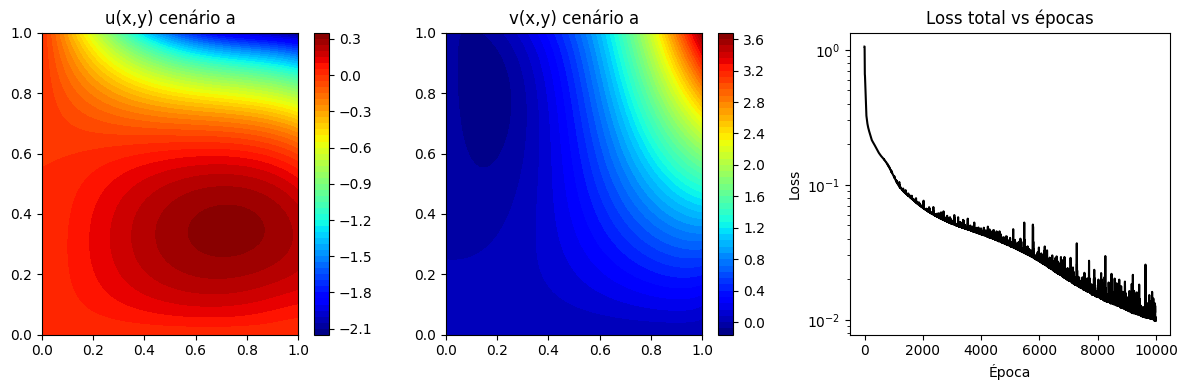

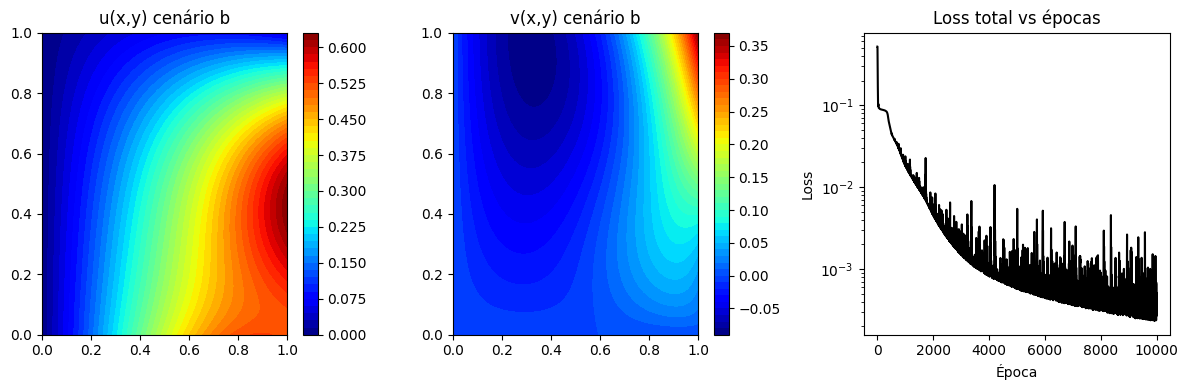

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as ag
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast # <-- Added import

device = torch.device('cuda')

# 1) Definição da PINN
class PINN_Elasticity(nn.Module):
    def __init__(self, hidden_layers, neurons, scenario):
        super().__init__()
        self.scenario = scenario  # 'a' ou 'b'
        layers = []
        layers.append(nn.Linear(2, neurons))
        for _ in range(hidden_layers-1):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(neurons, neurons))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(neurons, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, xy):
        x = xy[:,0:1]; y = xy[:,1:2]
        uv = self.net(xy)
        u_hat = uv[:,0:1]
        v_hat = uv[:,1:2]
        if self.scenario == 'a':
            u = x * y * u_hat
            v = x * y * v_hat
        else:  # cenário b
            u = x * u_hat
            v = x * y * v_hat
        return u, v

# 2) Amostragem de pontos
def sampler(n_int, n_bcs):
    # pontos internos (colocation)
    xi = torch.rand(n_int,2, device=device)
    # fronteira: x=0, x=1, y=0, y=1
    xb = torch.rand(n_bcs,2, device=device)
    # força ddeleta: forçar x=1 para tração σxx e σxy
    xb_traction = torch.cat([torch.ones(n_bcs//4,1),
                             torch.rand(n_bcs//4,1)], dim=1).to(device)
    return xi, xb, xb_traction

# 3) Cálculo das tensões e resíduos
E, nu = 1.0, 0.3
lambda_ = E*nu/((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))

def elasticity_residual(model, xi):
    xi.requires_grad_(True)
    u, v = model(xi)
    grads_u = ag.grad(u.sum(), xi, create_graph=True)[0]
    grads_v = ag.grad(v.sum(), xi, create_graph=True)[0]
    u_x, u_y = grads_u[:,0:1], grads_u[:,1:2]
    v_x, v_y = grads_v[:,0:1], grads_v[:,1:2]

    # tensões de Cauchy
    sigma_xx = (lambda_*(u_x+v_y) + 2*mu*u_x)
    sigma_yy = (lambda_*(u_x+v_y) + 2*mu*v_y)
    sigma_xy = mu*(u_y + v_x)

    # equilibrio (div σ = 0)
    eq1 = ag.grad(sigma_xx.sum(), xi, create_graph=True)[0][:,0:1] \
        + ag.grad(sigma_xy.sum(), xi, create_graph=True)[0][:,1:2]
    eq2 = ag.grad(sigma_xy.sum(), xi, create_graph=True)[0][:,0:1] \
        + ag.grad(sigma_yy.sum(), xi, create_graph=True)[0][:,1:2]
    return eq1, eq2, sigma_xx, sigma_xy

# 4) Função de perda
def loss_pinn(model, xi, xb, xb_tx, scenario):
    eq1, eq2, s_xx, s_xy = elasticity_residual(model, xi)
    l_pde = (eq1**2).mean() + (eq2**2).mean()

    # BC deslocamentos (hard integrado)

    # Tração x=1: impondo σxx e σxy
    xb_tx.requires_grad_(True)
    _, _, s_xx_b, s_xy_b = elasticity_residual(model, xb_tx)
    if scenario == 'a':
        tt = torch.ones_like(s_xx_b)
    else:
        y = xb_tx[:,1:2]
        tt = torch.sin(np.pi*y)
    l_tx = ((s_xx_b - tt)**2 + s_xy_b**2).mean()

    return l_pde + l_tx

# 5) Loop de treino
def train(scenario):
    model = PINN_Elasticity(4, 30, scenario).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()                          # <-- Mixed precision scaler

    xi, xb, xb_tx = sampler(10000, 2000)
    history = []

    for ep in range(1, 10001):
        optimizer.zero_grad()

        # Forward e cálculo de loss em half-precision quando possível
        with autocast():
            loss = loss_pinn(model, xi, xb, xb_tx, scenario)

        # Backward escalonado
        scaler.scale(loss).backward()

        # Atualiza parâmetros e o scaler
        scaler.step(optimizer)
        scaler.update()

        history.append(loss.item())
        if ep % 2000 == 0:
            print(f"Cenário {scenario} | Época {ep} | Loss {loss.item():.3e}")

    return model, history

# 6) Execução e resultados
model_a, hist_a = train('a')
model_b, hist_b = train('b')

# 7) Plot dos resultados
def plot_fields(model, scenario):
    N = 100
    xs = np.linspace(0,1,N)
    ys = np.linspace(0,1,N)
    XX, YY = np.meshgrid(xs, ys)
    xy = torch.tensor(np.vstack([XX.ravel(), YY.ravel()]).T,
                      dtype=torch.float32, device=device)
    u_pred, v_pred = model(xy)
    U = u_pred.detach().cpu().numpy().reshape(N,N)
    V = v_pred.detach().cpu().numpy().reshape(N,N)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.contourf(XX, YY, U, 50, cmap='jet'); plt.colorbar()
    plt.title(f'u(x,y) cenário {scenario}')

    plt.subplot(1,3,2)
    plt.contourf(XX, YY, V, 50, cmap='jet'); plt.colorbar()
    plt.title(f'v(x,y) cenário {scenario}')

    plt.subplot(1,3,3)
    hist = hist_a if scenario=='a' else hist_b
    plt.semilogy(hist, 'k-')
    plt.title('Loss total vs épocas')
    plt.xlabel('Época'); plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

plot_fields(model_a, 'a')
plot_fields(model_b, 'b')